In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from glob import glob

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.losses as losses

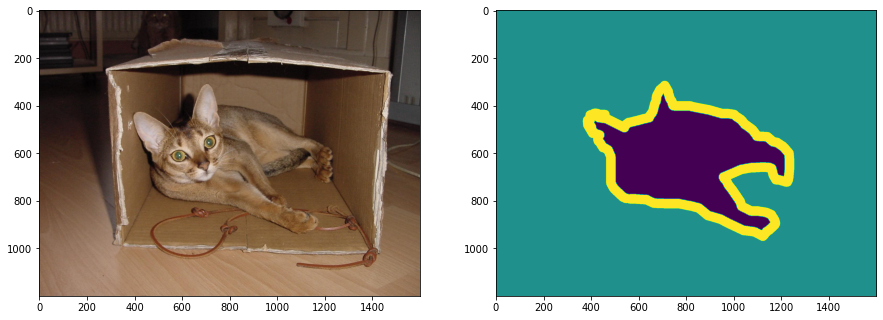

In [3]:
# \data\images 파일을 읽어와 134번 이미지를 선택
# \data\annotation\trimaps 선택하여 두 이미지를 화면에 시각화

image_files = glob('data/images/*.jpg')
image_path = image_files[134]
seg_path = image_path.replace('images', 'annotations/trimaps')
seg_path = seg_path.replace('jpg', 'png')

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
seg_map = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(seg_map)
plt.show()

# 1. IoU(Intersection over Union)
* object detector의 정확도를 측정하는데 이용되는 평가 지표
* ground-truth bounding boxes(testing set에서 object 위치를 labeling 한 것) 필요
* prediceted bounding boxes(model이 출력한 object 위치 예측값) 필요

  IoU = $\frac{Area of Overlap} {Area of Union}$

* Area of Overlap : prediceted bounding box와 ground-truth bounding box가 겹치는 부분
* Area of Union : prediceted bounding box와 ground-truth bounding box를 둘러싸는 영역
* IoU : 0.4(Poor), IoU : 0.7(Good), IoU : 0.9(Excellent)

In [4]:
def iou(y_true, y_pred):
    smooth = 0.
    
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum (y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    score = intersection / (union + smooth)
    return score

# 2. Dice Coefficient
* 이미지 등의 Segmentation에서 사용되는 지표
* 영상 이미지 등에서 정답과 예측값 간의 차이를 알기 위해 사용

    DSC = $\frac{2|X∩Y|} {|X| +|Y|}$
* 라벨링된 영역과 예측한 영역이 정확히 같다면 1, 그렇지 않은 경우는 0

In [5]:
def dice_coef(y_true, y_pred):
    smooth = 0.
    
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum (y_true * y_pred)
    score = (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    
    return score

In [6]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

In [7]:
def bce_dice_loss(y_true, y_pred):
    loss = 1.*losses.binary_crossentropy(t_true, y_pred) + 1.*dice_loss(y_true, y_pred)
    return loss

In [9]:
print(dice_coef(seg_map.astype('float32'), seg_map.astype('float32')).numpy())
print(iou(seg_map.astype('float32'), seg_map.astype('float32')).numpy())

2.041111
-49.64867
